Import Dependencies

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

Marking Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic 
mp_drawing = mp.solutions.drawing_utils 
mp_face_mesh = mp.solutions.face_mesh

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                 
    results = model.process(image)                
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results


In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_TESSELATION,
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 ) 
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 ) 
    # Draw left hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 ) 
    # Draw right hand connections  
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 ) 


Extracting Keypoint Values

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])


Setting up Folders for Collection of Data

In [6]:
DATA_PATH = os.path.join('MP_Data') 
actions = np.array(['hello', 'thanks', 'iloveyou'])
no_sequences = 30
sequence_length = 30

In [7]:
for action in actions: 
    for sequence in range(1, no_sequences + 1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

Collecting Keypoint Values for Training and Testing Set Data

In [9]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    for action in actions:
        
        for sequence in range(1, no_sequences + 1):
            
            for frame_num in range(sequence_length):
                
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                draw_styled_landmarks(image, results)
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    
    cap.release()
    cv2.destroyAllWindows()

c:\Users\Nishant\OneDrive\Desktop\sign\env\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Preprocessing Data and Creating Labels and Features for Model Training

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [11]:
label_map = {label:num for num, label in enumerate(actions)}

In [12]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [13]:
sequences, labels = [], []
for action in actions:
    for sequence in range(1,no_sequences+1):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [14]:
X = np.array(sequences)

In [15]:
Y = to_categorical(labels).astype(int)

In [16]:
X_train, X_test , Y_train, Y_test = train_test_split(X, Y, test_size=0.05)

Building and Training LSTM Neural Network

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import TensorBoard

In [18]:
log_dir = os.path.join("Logs")
tb_callback = TensorBoard(log_dir=log_dir)

In [35]:
model= Sequential()
model.add(Input(shape=(30, 1662)))
model.add(LSTM(64, return_sequences= True, activation= 'relu'))
model.add(LSTM(128, return_sequences= True, activation= 'relu'))
model.add(LSTM(128, return_sequences= False, activation= 'relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32, activation= 'relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,947 (2.61 MB)

 Trainable params: 682,947 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, Y_train, epochs= 2000, callbacks=[tb_callback])


Make Predictions

In [28]:
res= model.predict((X_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


In [29]:
actions[np.argmax(res[4])]

'thanks'

In [31]:
actions[np.argmax(Y_test[4])]

'thanks'

Saving Weights

In [32]:
model.save('sign.h5')

In [33]:
del  model

In [37]:
model.load_weights('sign.h5')

Evaluation using Confusion Matrix and Accuracy

In [38]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [39]:
yhat  = model.predict(X_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step


In [40]:
ytrue = np.argmax(Y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [41]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[54,  3],
        [ 0, 28]],

       [[58,  0],
        [ 0, 27]],

       [[55,  0],
        [ 3, 27]]], dtype=int64)

In [42]:
accuracy_score(ytrue ,yhat)

0.9647058823529412

Test in Real Time

In [43]:
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]  # Add as many colors as needed
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

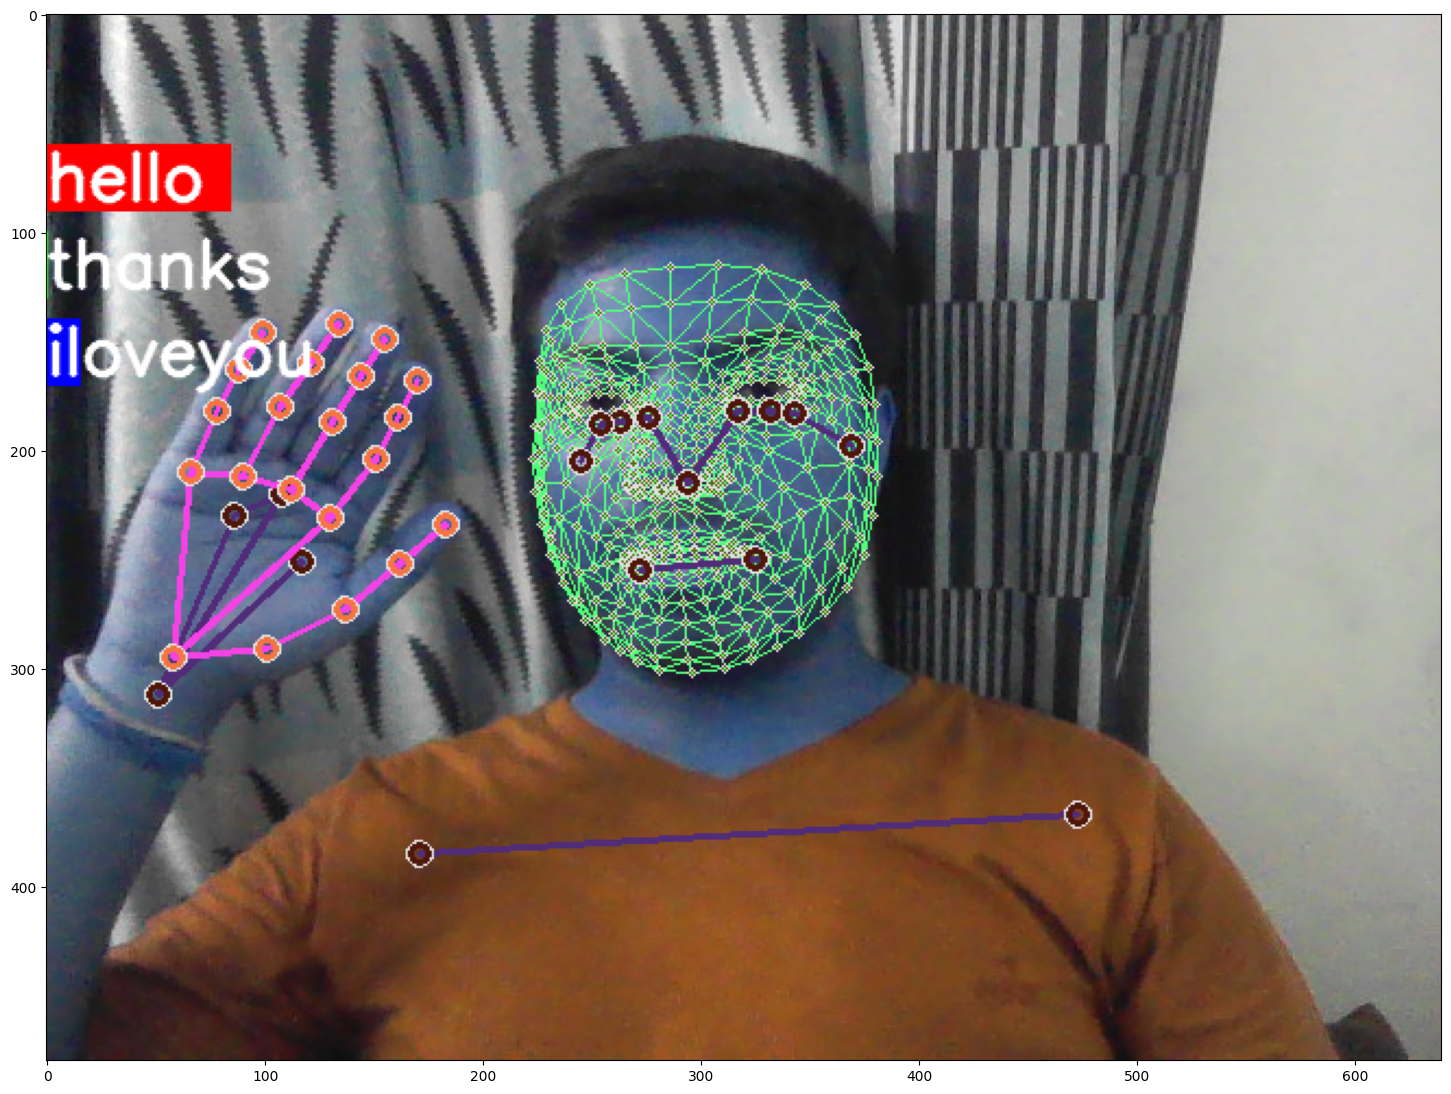

: 

In [46]:
plt.figure(figsize=(18,18))

plt.imshow(prob_viz(res, actions, image, colors))